# Risk assessment

- A workflow from the CLIMAAX [Handbook](https://handbook.climaax.eu/) and [FIRE](https://github.com/CLIMAAX/FIRE) GitHub repository.
- See our [how to use risk workflows](https://handbook.climaax.eu/notebooks/workflows_how_to.html) page for information on how to run this notebook.

Combine FWI-based hazard with population projections to create am assessment of fire risk for the population.
Include uncertainty estimate from hazard.

## Preparation work

### Load libraries

:::{admonition} Information about the libraries used in this workflow
:class: hint dropdown

- [os]() - TODO
- [pathlib](https://docs.python.org/3/library/os.html) - Convenient file path manipulation for Python.
- [zipfile] - TODO
- [numpy](https://numpy.org/) - A powerful library for numerical computations in Python, widely used for array operations and mathematical functions.
- [pandas](https://pandas.pydata.org/) - A data manipulation and analysis library, essential for working with structured data in tabular form.
- [xarray](https://docs.xarray.dev/en/stable/) - Library for working with labelled multi-dimensional arrays.
- [earthkit.plots](https://earthkit-plots.readthedocs.io/en/latest/) - Visualisation tools and templates designed for earth science data.
- [matplotlib](https://matplotlib.org) - TODO
- TODO
:::

In [1]:
import os
import pathlib
import zipfile

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pooch
import xarray as xr
import earthkit.plots as ekp

### Set location

Used for labelling and to locate data from previous steps of the workflow.

In [2]:
location = "Cataluña"

### Path configuration

In [3]:
data_dir = pathlib.Path("./data")

# Shapefile of region that is analysed
region_path = data_dir / location / "region"

# Folder for population data
pop_dir = data_dir / "population"

### Load region geometry

In [4]:
region = gpd.read_file(region_path)

## Step 1: Import hazard projections

Import the hazard projections constructed in the final notebook of the hazard assessment.

In [5]:
hazard = xr.open_dataarray(data_dir / location / "hazard_pe_fwi_40.0.nc")
hazard = hazard.rio.write_crs("EPSG:4326")
hazard = hazard.rename({"lon": "x", "lat": "y"})

## Step 2: Prepare population projections

[Wang et al. (2022)](https://doi.org/10.6084/m9.figshare.19608594.v3) have modelled the global population distribution from 2020 to 2100 in 5-year steps under five shared socioeconomic pathway (SSP) scenarios:

- `SSP1`: "Taking the Green Road"
- `SSP2`: "Middle of the Road"
- `SSP3`: "A Rocky Road"
- `SSP4`: "A Road Divided"
- `SSP5`: "Taking the Highway"

### Select a scenario

In [6]:
ssp = "SSP1"

### Download data

Projections are available in GeoTIFF format packaged into a zip archive per SSP.

:::{tip}

Skip this substep if you already downloaded the data.
:::

In [99]:
population_pooch = pooch.create(
    base_url="doi:10.6084/m9.figshare.19608594.v3",
    path=pop_dir,
    registry={
        "SPP1.zip": "3ec4587810b7ca5201d2a19bf37fc447a88559b3841aadbf675d9c3a738c285e",
        "SSP2.zip": "00d7f9e79504c1936ba86b0857c7e7ac4015f9a05a3e13d328f9487bec6eddd7",
        "SSP3.zip": "f8de3ef275d3fb40b11a0d65259639f40286f95a42d57d60fde5a7967a2d91d1",
        "SSP4.zip": "e307e0eff29c1ae91d99bd9a8ae4498b122b01e59329d75e544d11641db8defb",
        "SSP5.zip": "2af4b5f9886db0153d4dbd0ba229078baeeab3fe355906d40eb034835cad5190",
    }
)

In [101]:
# Exception for a typo in the scenario names in the data repository
population_filename = "SPP1.zip" if ssp == "SSP1" else f"{ssp}.zip"

# Download from repository
population_filename = population_pooch.fetch(population_filename, progressbar=True)

Unpack all GeoTIFF files from the downloaded archive into the population data folder:

In [ ]:
with zipfile.ZipFile(pop_archive) as zobj:
    # Extract without keeping structure (https://stackoverflow.com/a/47632134)
    for zinfo in zobj.infolist():
        if not zinfo.filename.endswith(".tif"):
            continue
        zinfo.filename = os.path.basename(zinfo.filename)
        zobj.extract(zinfo, path=pop_dir)

Remove the archive to reduce disk usage:

In [ ]:
os.remove(pop_archive)

### Import and clip data

Load the population projections for all years:

In [7]:
def assign_year(ds):
    """Assign a year coordinate based on value extracted from the filename"""
    year = int(ds.encoding["source"][-8:-4])
    return ds.squeeze().assign_coords({"year": year})

population = xr.open_mfdataset(
    sorted(pop_dir.glob(f"{ssp}_*.tif")),
    engine="rasterio",
    preprocess=assign_year,
    concat_dim="year",
    combine="nested",
    chunks="auto"
)

Preselect and set metadata for convenience:

In [8]:
population = population["band_data"].rename("population").squeeze()

Only keep population data for the region of interest:

In [9]:
# Population data is on lat-lon grid. Preselect with the bounding box of
# the region shapefile to speed up clipping with rasterio 
bbox = region.total_bounds
population = population.sel({
    "x": slice(bbox[0], bbox[2]),
    "y": slice(bbox[3], bbox[1])
}).compute()

# Now clip to the actual region boundaries
population = population.rio.clip(region.geometry, all_touched=True)

### Evolution of the total population

Sum across the region to get the total population:

In [10]:
total_population = population.sum(dim=["x", "y"])

For a first look at the population data, visualize the projected evolution of the total population and a population map for the year where the population count is greatest:

/opt/conda/lib/python3.11/site-packages/earthkit/plots/metadata/labels.py:121: UserWarning: No key "units" found in layer metadata.
  warnings.warn(f'No key "{attr}" found in layer metadata.')


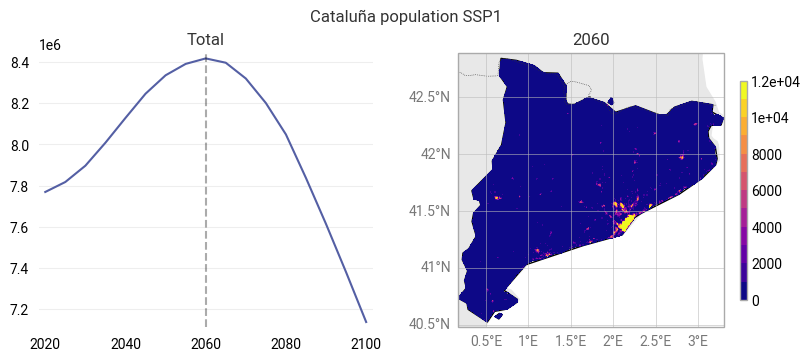

In [13]:
fig = ekp.Figure(rows=1, columns=2, size=(8, 3.5))
fig.title(f"{location} population {ssp}")

# Determine the year at which the population is largest (or choose a year of interest)
year = int(total_population.idxmax().values)

# Temporal evolution of the total population
subplot = fig.add_subplot()
subplot.title("total")
subplot.line(x=population["year"].values, y=total_population.values)
subplot.ax.axvline(year, color="black", alpha=0.33, linestyle="dashed")

# Population map for the year of interest
subplot = fig.add_map()
subplot.title(f"{year}")
region.plot(ax=subplot.ax, edgecolor="black", facecolor="none")  # Outline of selected region
subplot.block(population.sel({"year": year}))
subplot.legend(location="right")
subplot.land()
subplot.borders()
subplot.gridlines()

:::{note}

The values in the population map indicate the number of inhabitants per grid cell.
:::

## Step 3: Compute risk

Combine the projections of wildfire hazard and population to determine the future risk of wildfire conditions for the inhabitant of the area of interest.

### Count the affected population

In [14]:
def sum_where_threshold_exceeded(data_sum, data_where, threshold):
    # Grid points where threshold is exceeded
    mask = data_where >= threshold
    # Sum population over grid points within the bin range
    counts = mask.weighted(data_sum.fillna(0)).sum(dim=["y", "x"])
    # Add bin range coordinates to output
    return counts.assign_coords({"threshold": threshold})


def affected_population(hazard, population, thresholds, decade):
    # Hazard data is given in 10 year steps with each data point representative of a decade,
    # e.g., decade 2030 represents years 2030-2039 (inclusive). The population data is given
    # in 5 year steps with each value representing the year for which it is valid. To align,
    # select the middle year of each decade to represent the population of that decade. E.g.,
    # for decade 2030-2039, take the population projection for 2035.
    population = population.sel({"year": decade + 5})
    
    # Resample to the grid of the highest-resolution dataset. This likely means resampling
    # the hazard data to match the population data. Select only data from the selected
    # decade (rioxarray will only reproject datasets of up to 3 dimensions, so one of "run"
    # and "decade" has to be eliminated).
    hazard = hazard.sel({"decade": decade}).rio.reproject_match(population)
    
    # Sum the population for each threshold (could also be implemented with numpy's digitize,
    # bincount and cumsum, but only cumsum has an xarray equivalent)
    counts = xr.concat(
        [sum_where_threshold_exceeded(population, hazard, threshold) for threshold in thresholds],
        dim="threshold"
    )
    return counts.assign_coords({"decade": decade}).rename("affected_population")

Split the value range of the hazard indicator into a set of discrete bins and count the population where the the hazard indicator exceeds 

In [15]:
# Decades to evaluate
decades = [2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090]

# Value ranges for the hazard (adapt to the selected hazard indicator)
# Default: probability of exceedance from 0% to 100% in steps of 1%
hazard_thresholds = np.linspace(0, 100, 101)

# Count for all decades and model runs
counts = xr.concat(
    [affected_population(hazard, population, hazard_thresholds, decade) for decade in decades],
    dim="decade"
)

### Visualization

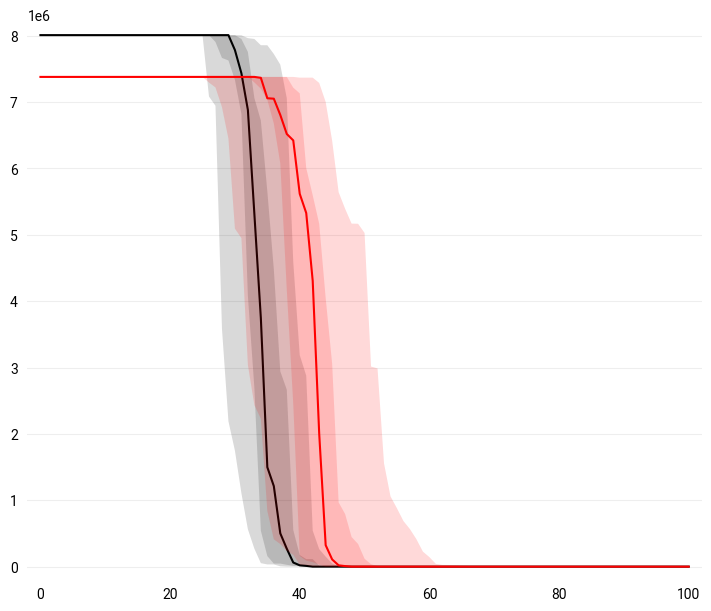

In [16]:
subplot = ekp.Subplot()
subplot.quantiles(counts.sel({"decade": 2030}), x=counts["threshold"], dim="run", quantiles=[0.0, 0.25, 0.5, 0.75, 1.0], color="black")
subplot.quantiles(counts.sel({"decade": 2090}), x=counts["threshold"], dim="run", quantiles=[0.0, 0.25, 0.5, 0.75, 1.0], color="red")

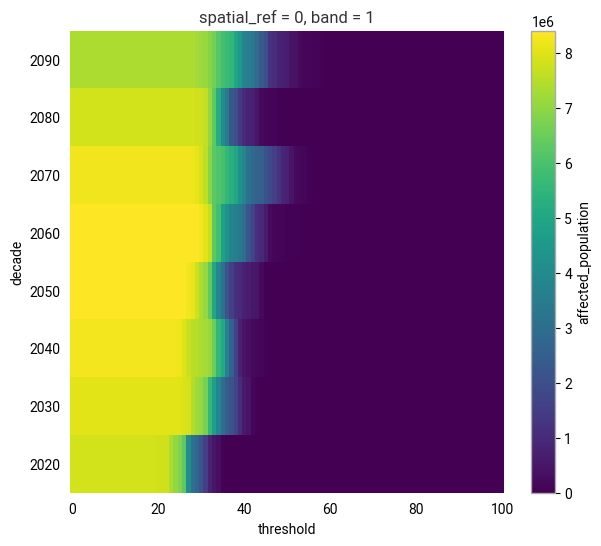

In [17]:
counts.mean(dim="run").plot.pcolormesh()

### Interpretation

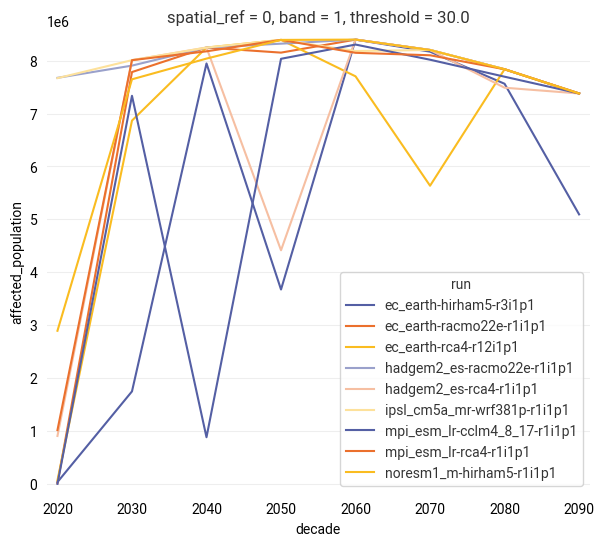

In [27]:
counts.sel({"threshold": 30}).plot.line(x="decade")

In [30]:
subplot.quantiles(
    counts.sel({"threshold": 30}),
    x=counts["decade"],
    dim="run",
    quantiles=[0.0, 0.25, 0.5, 0.75, 1.0]
)

## Data export

## Conclusions

TODO